In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score , RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.ensemble import RandomForestClassifier

import shap
from shap import TreeExplainer


# 0. Set preliminaries

In [15]:
# Define the scoring metric with the positive label specified
# Depression = 1
scorer = make_scorer(f1_score, pos_label=1) 

In [16]:
# Set display settings: Turning off scientific notation and getting max column width displays
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)

# 1. Load in the dataset

In [ ]:
df = pd.read_csv('../Data/Combined_sets/data_rq1.tsv', header=[0,1], index_col=[0], sep='\t')

gender           age                       Affect                    \
          male female  19-29  30-39   <=18   >=40 mean_NA   NAV mean_affect   
user_id                                                                       
uDEP000   True  False  False  False  False  False   0.137 0.099       0.137   
uDEP001   True  False  False  False  False   True   0.171 0.120       0.171   
uDEP002   True  False  False  False  False   True   0.150 0.104       0.150   
uDEP004  False  False  False  False   True  False   0.162 0.120       0.162   
uDEP005  False   True  False  False  False   True   0.156 0.099       0.156   

                            Tweet_Count                                \
           AV mean_PA   PAV    timeline mean_words sd_words min_words   
user_id                                                                 
uDEP000 0.508   0.172 0.123         871     25.518   14.604         2   
uDEP001 0.527   0.184 0.127        1367     22.662   14.836         1   
uDEP002 0.506   0.259 0.144        2592     19.253   12.989         1   
uDEP004 0.534   0.216 0.147        2711     22.279   14.649         1   
uDEP005 0.525   0.162 0.114        3026     24.843   15.069         2   

                                                                         \
        max_words log_words mean_punct mean_exclam log_punct log_exclam   
user_id                                                                   
uDEP000        62    14.440      4.752       0.079    12.015      6.129   
uDEP001        59    14.919      3.230       0.223    12.109      8.257   
uDEP002        69    15.607      3.759       0.494    13.250     10.323   
uDEP004        66    15.882      3.830       0.221    13.342      9.226   
uDEP005        67    16.198      5.218       0.122    13.947      8.531   

                       Emojis                                          \
        mentions_p mean_emoji log_total_emoji neg_emoji_p pos_emoji_p   
user_id                                                                 
uDEP000      0.956      0.006           2.585       0.000       0.000   
uDEP001      0.326      0.008           3.585       0.182       0.000   
uDEP002      1.350      1.107          11.487       0.014       0.265   
uDEP004      0.868      0.053           7.170       0.042       0.434   
uDEP005      1.734      0.003           3.322       0.444       0.000   

              CDS_prevalence                                        \
        labeling_mislabeling catastrophising dichotomous_reasoning   
user_id                                                              
uDEP000                0.033           0.000                 0.185   
uDEP001                0.034           0.000                 0.228   
uDEP002                0.032           0.001                 0.181   
uDEP004                0.043           0.000                 0.176   
uDEP005                0.041           0.000                 0.234   

                                                                               \
        emotional_reasoning disqualifying_positive magnification_minimisation   
user_id                                                                         
uDEP000               0.002                  0.005                      0.026   
uDEP001               0.001                  0.006                      0.029   
uDEP002               0.000                  0.002                      0.037   
uDEP004               0.001                  0.003                      0.018   
uDEP005               0.000                  0.002                      0.021   

                                                                        \
        mental_filtering mindreading fortunetelling overgeneralisation   
user_id                                                                  
uDEP000            0.001       0.010          0.008              0.013   
uDEP001            0.002       0.029          0.002              0.010   
uDEP002            0.000

In [19]:
columns_list = df.columns.to_list()
# Remove the label column
columns_list = columns_list[:-1]

In [20]:
# Check
print(columns_list)

[('gender', 'male'), ('gender', 'female'), ('age', '19-29'), ('age', '30-39'), ('age', '<=18'), ('age', '>=40'), ('Affect', 'mean_NA'), ('Affect', 'NAV'), ('Affect', 'mean_affect'), ('Affect', 'AV'), ('Affect', 'mean_PA'), ('Affect', 'PAV'), ('Tweet_Count', 'timeline'), ('Tweet_Count', 'sd_words'), ('Tweet_Count', 'min_words'), ('Tweet_Count', 'max_words'), ('Tweet_Count', 'mean_punct'), ('Tweet_Count', 'mean_exclam'), ('Tweet_Count', 'log_punct'), ('Tweet_Count', 'log_exclam'), ('Tweet_Count', 'mentions_p'), ('Emojis', 'mean_emoji'), ('Emojis', 'log_total_emoji'), ('Emojis', 'neg_emoji_p'), ('Emojis', 'pos_emoji_p'), ('CDS_prevalence', 'labeling_mislabeling'), ('CDS_prevalence', 'catastrophising'), ('CDS_prevalence', 'dichotomous_reasoning'), ('CDS_prevalence', 'emotional_reasoning'), ('CDS_prevalence', 'disqualifying_positive'), ('CDS_prevalence', 'magnification_minimisation'), ('CDS_prevalence', 'mental_filtering'), ('CDS_prevalence', 'mindreading'), ('CDS_prevalence', 'fortunetelli

In [21]:
df = df.fillna(0)

# 2. Dataset split and scaling

In [22]:
y = df[("target", "diagnosis")]
X = df.drop([("target", "diagnosis")], axis=1)

In [23]:
# Perform stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)


## 2.2 Scaling

In [24]:
# Initialize the MinMaxScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train = scaler.fit_transform(X_train)

# Transform the validation and test data using the scaler fitted on the training data
X_test = scaler.transform(X_test)


# 3. Random Forest Performance

We used RandomizedSearchCV, so to control for the randomization, we set n_iter to 100 and repeated the model fit 10 times, then taking the best result and hyperparameters from those.

### 1

In [ ]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(1,500),
    'max_depth': np.arange(1,50),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=100,  
    scoring=scorer,  
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the validation data
random_search_rf.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_rf.best_params_)
print("Best f1 score found: ", random_search_rf.best_score_)

# Evaluate the best model on the test data using scaled data
best_rf_model = random_search_rf.best_estimator_
y_test_pred_rf = best_rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf, pos_label=1)
precision_rf = precision_score(y_test, y_test_pred_rf, pos_label=1)
recall_rf = recall_score(y_test, y_test_pred_rf, pos_label=1)

print("\nEvaluation of the best RF Classifier model on the test set:")
print("Test accuracy:", accuracy_rf)
print("Test precision:", precision_rf)
print("Test recall:", recall_rf)
print("Test f1 score:", f1_rf)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'n_estimators': np.int64(459), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': np.int64(28), 'criterion': 'log_loss', 'bootstrap': True}
Best f1 score found:  0.8318548043679648

Evaluation of the best RF Classifier model on the test set:
Test accuracy: 0.8305555555555556
Test precision: 0.8048780487804879
Test recall: 0.8870967741935484
Test f1 score: 0.8439897698209718


### 2

In [ ]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(1,500),
    'max_depth': np.arange(1,50),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=100,  
    scoring=scorer,  
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the validation data
random_search_rf.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_rf.best_params_)
print("Best f1 score found: ", random_search_rf.best_score_)

# Evaluate the best model on the test data using scaled data
best_rf_model = random_search_rf.best_estimator_
y_test_pred_rf = best_rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf, pos_label=1)
precision_rf = precision_score(y_test, y_test_pred_rf, pos_label=1)
recall_rf = recall_score(y_test, y_test_pred_rf, pos_label=1)

print("\nEvaluation of the best RF Classifier model on the test set:")
print("Test accuracy:", accuracy_rf)
print("Test precision:", precision_rf)
print("Test recall:", recall_rf)
print("Test f1 score:", f1_rf)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'n_estimators': np.int64(459), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': np.int64(28), 'criterion': 'log_loss', 'bootstrap': True}
Best f1 score found:  0.8318548043679648

Evaluation of the best RF Classifier model on the test set:
Test accuracy: 0.8305555555555556
Test precision: 0.8048780487804879
Test recall: 0.8870967741935484
Test f1 score: 0.8439897698209718


### 3

In [ ]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(1,500),
    'max_depth': np.arange(1,50),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=100,  
    scoring=scorer,  
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1 
)

# Fit RandomizedSearchCV to the validation data
random_search_rf.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_rf.best_params_)
print("Best f1 score found: ", random_search_rf.best_score_)

# Evaluate the best model on the test data using scaled data
best_rf_model = random_search_rf.best_estimator_
y_test_pred_rf = best_rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf, pos_label=1)
precision_rf = precision_score(y_test, y_test_pred_rf, pos_label=1)
recall_rf = recall_score(y_test, y_test_pred_rf, pos_label=1)

print("\nEvaluation of the best RF Classifier model on the test set:")
print("Test accuracy:", accuracy_rf)
print("Test precision:", precision_rf)
print("Test recall:", recall_rf)
print("Test f1 score:", f1_rf)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'n_estimators': np.int64(459), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': np.int64(28), 'criterion': 'log_loss', 'bootstrap': True}
Best f1 score found:  0.8318548043679648

Evaluation of the best RF Classifier model on the test set:
Test accuracy: 0.8305555555555556
Test precision: 0.8048780487804879
Test recall: 0.8870967741935484
Test f1 score: 0.8439897698209718


### 4

In [ ]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(1,500),
    'max_depth': np.arange(1,50),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=100,   
    scoring=scorer,  
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1   
)

# Fit RandomizedSearchCV to the validation data
random_search_rf.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_rf.best_params_)
print("Best f1 score found: ", random_search_rf.best_score_)

# Evaluate the best model on the test data using scaled data
best_rf_model = random_search_rf.best_estimator_
y_test_pred_rf = best_rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf, pos_label=1)
precision_rf = precision_score(y_test, y_test_pred_rf, pos_label=1)
recall_rf = recall_score(y_test, y_test_pred_rf, pos_label=1)

print("\nEvaluation of the best RF Classifier model on the test set:")
print("Test accuracy:", accuracy_rf)
print("Test precision:", precision_rf)
print("Test recall:", recall_rf)
print("Test f1 score:", f1_rf)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'n_estimators': np.int64(459), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': np.int64(28), 'criterion': 'log_loss', 'bootstrap': True}
Best f1 score found:  0.8318548043679648

Evaluation of the best RF Classifier model on the test set:
Test accuracy: 0.8305555555555556
Test precision: 0.8048780487804879
Test recall: 0.8870967741935484
Test f1 score: 0.8439897698209718


### 5

In [ ]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(1,500),
    'max_depth': np.arange(1,50),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=100,   
    scoring=scorer,    
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1   
)

# Fit RandomizedSearchCV to the validation data
random_search_rf.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_rf.best_params_)
print("Best f1 score found: ", random_search_rf.best_score_)

# Evaluate the best model on the test data using scaled data
best_rf_model = random_search_rf.best_estimator_
y_test_pred_rf = best_rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf, pos_label=1)
precision_rf = precision_score(y_test, y_test_pred_rf, pos_label=1)
recall_rf = recall_score(y_test, y_test_pred_rf, pos_label=1)

print("\nEvaluation of the best RF Classifier model on the test set:")
print("Test accuracy:", accuracy_rf)
print("Test precision:", precision_rf)
print("Test recall:", recall_rf)
print("Test f1 score:", f1_rf)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'n_estimators': np.int64(459), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': np.int64(28), 'criterion': 'log_loss', 'bootstrap': True}
Best f1 score found:  0.8318548043679648

Evaluation of the best RF Classifier model on the test set:
Test accuracy: 0.8305555555555556
Test precision: 0.8048780487804879
Test recall: 0.8870967741935484
Test f1 score: 0.8439897698209718


### 6

In [ ]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(1,500),
    'max_depth': np.arange(1,50),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=100,   
    scoring=scorer,    
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1   
)

# Fit RandomizedSearchCV to the validation data
random_search_rf.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_rf.best_params_)
print("Best f1 score found: ", random_search_rf.best_score_)

# Evaluate the best model on the test data using scaled data
best_rf_model = random_search_rf.best_estimator_
y_test_pred_rf = best_rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf, pos_label=1)
precision_rf = precision_score(y_test, y_test_pred_rf, pos_label=1)
recall_rf = recall_score(y_test, y_test_pred_rf, pos_label=1)

print("\nEvaluation of the best RF Classifier model on the test set:")
print("Test accuracy:", accuracy_rf)
print("Test precision:", precision_rf)
print("Test recall:", recall_rf)
print("Test f1 score:", f1_rf)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'n_estimators': np.int64(459), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': np.int64(28), 'criterion': 'log_loss', 'bootstrap': True}
Best f1 score found:  0.8318548043679648

Evaluation of the best RF Classifier model on the test set:
Test accuracy: 0.8305555555555556
Test precision: 0.8048780487804879
Test recall: 0.8870967741935484
Test f1 score: 0.8439897698209718


### 7

In [ ]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(1,500),
    'max_depth': np.arange(1,50),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=100,   
    scoring=scorer,    
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1   
)

# Fit RandomizedSearchCV to the validation data
random_search_rf.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_rf.best_params_)
print("Best f1 score found: ", random_search_rf.best_score_)

# Evaluate the best model on the test data using scaled data
best_rf_model = random_search_rf.best_estimator_
y_test_pred_rf = best_rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf, pos_label=1)
precision_rf = precision_score(y_test, y_test_pred_rf, pos_label=1)
recall_rf = recall_score(y_test, y_test_pred_rf, pos_label=1)

print("\nEvaluation of the best RF Classifier model on the test set:")
print("Test accuracy:", accuracy_rf)
print("Test precision:", precision_rf)
print("Test recall:", recall_rf)
print("Test f1 score:", f1_rf)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'n_estimators': np.int64(459), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': np.int64(28), 'criterion': 'log_loss', 'bootstrap': True}
Best f1 score found:  0.8318548043679648

Evaluation of the best RF Classifier model on the test set:
Test accuracy: 0.8305555555555556
Test precision: 0.8048780487804879
Test recall: 0.8870967741935484
Test f1 score: 0.8439897698209718


### 8

In [ ]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(1,500),
    'max_depth': np.arange(1,50),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=100,   
    scoring=scorer,    
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1   
)

# Fit RandomizedSearchCV to the validation data
random_search_rf.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_rf.best_params_)
print("Best f1 score found: ", random_search_rf.best_score_)

# Evaluate the best model on the test data using scaled data
best_rf_model = random_search_rf.best_estimator_
y_test_pred_rf = best_rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf, pos_label=1)
precision_rf = precision_score(y_test, y_test_pred_rf, pos_label=1)
recall_rf = recall_score(y_test, y_test_pred_rf, pos_label=1)

print("\nEvaluation of the best RF Classifier model on the test set:")
print("Test accuracy:", accuracy_rf)
print("Test precision:", precision_rf)
print("Test recall:", recall_rf)
print("Test f1 score:", f1_rf)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'n_estimators': np.int64(459), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': np.int64(28), 'criterion': 'log_loss', 'bootstrap': True}
Best f1 score found:  0.8318548043679648

Evaluation of the best RF Classifier model on the test set:
Test accuracy: 0.8305555555555556
Test precision: 0.8048780487804879
Test recall: 0.8870967741935484
Test f1 score: 0.8439897698209718


### 9

In [ ]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(1,500),
    'max_depth': np.arange(1,50),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=100,   
    scoring=scorer,    
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1   
)

# Fit RandomizedSearchCV to the validation data
random_search_rf.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_rf.best_params_)
print("Best f1 score found: ", random_search_rf.best_score_)

# Evaluate the best model on the test data using scaled data
best_rf_model = random_search_rf.best_estimator_
y_test_pred_rf = best_rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf, pos_label=1)
precision_rf = precision_score(y_test, y_test_pred_rf, pos_label=1)
recall_rf = recall_score(y_test, y_test_pred_rf, pos_label=1)

print("\nEvaluation of the best RF Classifier model on the test set:")
print("Test accuracy:", accuracy_rf)
print("Test precision:", precision_rf)
print("Test recall:", recall_rf)
print("Test f1 score:", f1_rf)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'n_estimators': np.int64(459), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': np.int64(28), 'criterion': 'log_loss', 'bootstrap': True}
Best f1 score found:  0.8318548043679648

Evaluation of the best RF Classifier model on the test set:
Test accuracy: 0.8305555555555556
Test precision: 0.8048780487804879
Test recall: 0.8870967741935484
Test f1 score: 0.8439897698209718


### 10

In [ ]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(1,500),
    'max_depth': np.arange(1,50),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=100,   
    scoring=scorer,    
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1   
)

# Fit RandomizedSearchCV to the validation data
random_search_rf.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_rf.best_params_)
print("Best f1 score found: ", random_search_rf.best_score_)

# Evaluate the best model on the test data using scaled data
best_rf_model = random_search_rf.best_estimator_
y_test_pred_rf = best_rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf, pos_label=1)
precision_rf = precision_score(y_test, y_test_pred_rf, pos_label=1)
recall_rf = recall_score(y_test, y_test_pred_rf, pos_label=1)

print("\nEvaluation of the best RF Classifier model on the test set:")
print("Test accuracy:", accuracy_rf)
print("Test precision:", precision_rf)
print("Test recall:", recall_rf)
print("Test f1 score:", f1_rf)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'n_estimators': np.int64(459), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': np.int64(28), 'criterion': 'log_loss', 'bootstrap': True}
Best f1 score found:  0.8318548043679648

Evaluation of the best RF Classifier model on the test set:
Test accuracy: 0.8305555555555556
Test precision: 0.8048780487804879
Test recall: 0.8870967741935484
Test f1 score: 0.8439897698209718


Confusion Matrix

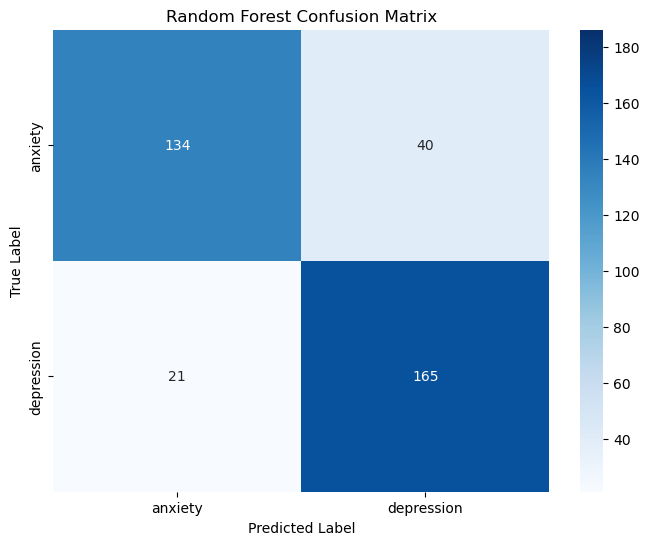

In [35]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_rf, labels=[0, 1])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['anxiety', 'depression'], yticklabels=['anxiety', 'depression'],vmax=186)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()

# RQ2: Feature importances

SHAP calculation with LinearExplainer

In [36]:
# explain all the predictions in the test set
explainer_rf = shap.TreeExplainer(best_rf_model, X_train)
shap_values_rf = explainer_rf.shap_values(X_test)

 98%|===================| 702/720 [00:36<00:00]        

Beeswarm plot for positive depression class, top 20

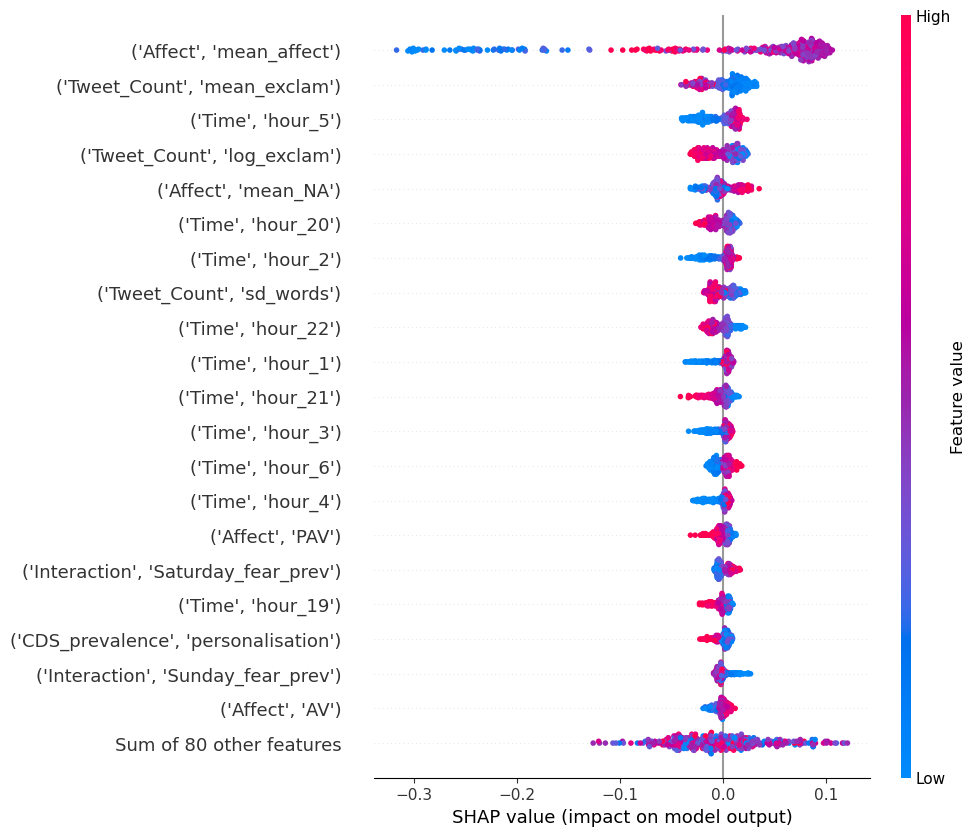

In [39]:

# Shap_values[1] corresponds to the 'depression' class

# Ensure feature names are correctly extracted from a DataFrame (e.g., X_train) and flattened
feature_names_for_shap = columns_list

# Determine the correct way to extract SHAP values for the 'depression' class (index 1)
values_for_plot = None
if isinstance(shap_values_rf, list):

    values_for_plot = shap_values_rf[1]
elif isinstance(shap_values_rf, np.ndarray) and shap_values_rf.ndim == 3:

    values_for_plot = shap_values_rf[:, :, 1]
else:
    raise ValueError("Unexpected structure for shap_values. Expected a list of 2D arrays or a 3D array.")

# Ensure the number of samples matches between SHAP values and data matrix
num_shap_samples = values_for_plot.shape[1]
num_data_samples = X_test.shape[1]

if num_shap_samples != num_data_samples:
    print(f"Warning: SHAP values have {num_shap_samples} samples, but data matrix has {num_data_samples}. Truncating data to match.")
    min_samples = min(num_shap_samples, num_data_samples)
    values_for_plot = values_for_plot[:min_samples, :]
    X_test = X_test[:min_samples, :]
else:
    X_test = X_test

# Create a shap.Explanation object
shap_explanation = shap.Explanation(
    values=values_for_plot, 
    base_values=explainer_rf.expected_value[1], 
    data=X_test, 
    feature_names=feature_names_for_shap 
)

# Now call shap.plots.beeswarm with the Explanation object
shap.plots.beeswarm(shap_explanation, max_display=21)

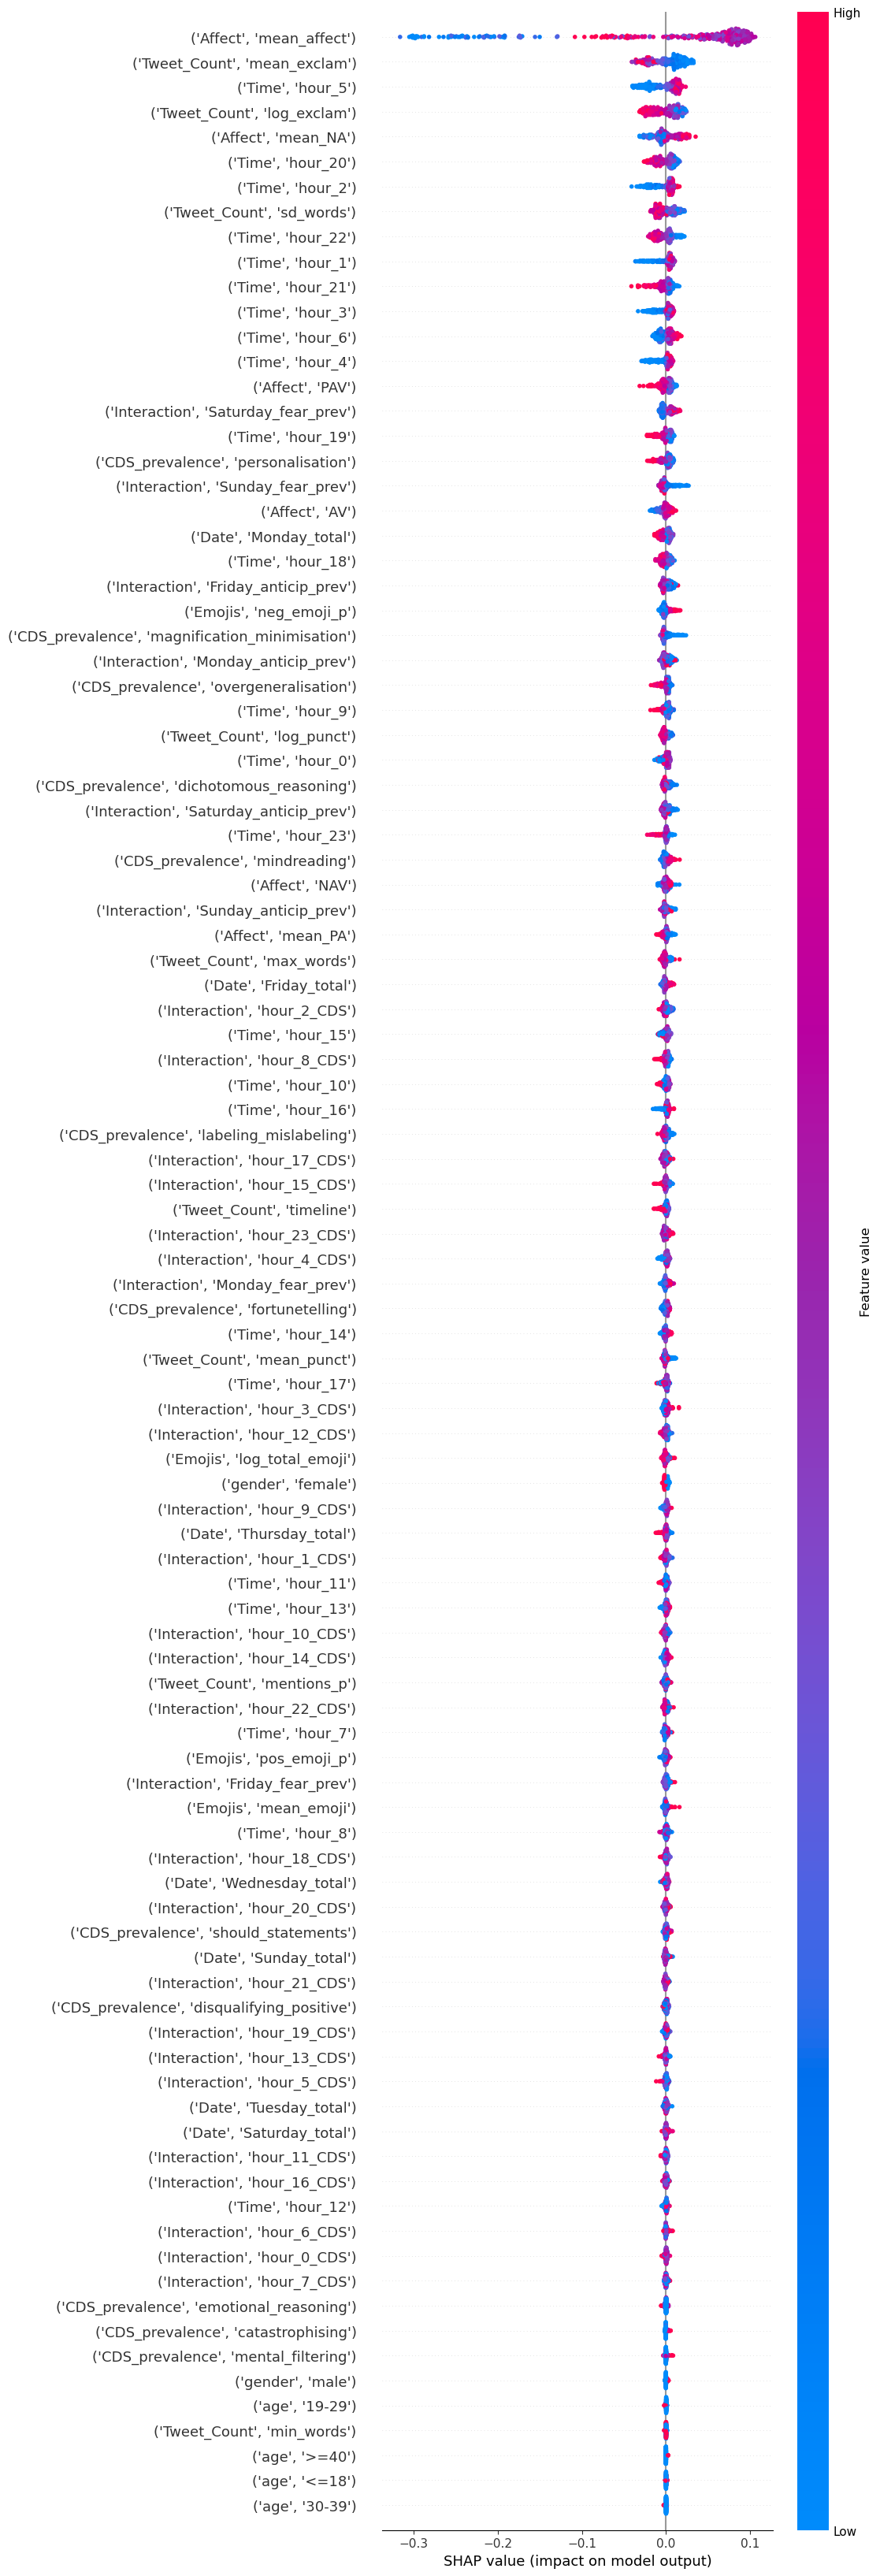

In [40]:

# Shap_values[1] corresponds to the 'depression' class

# Ensure feature names are correctly extracted from a DataFrame (e.g., X_train) and flattened
feature_names_for_shap = columns_list

# Determine the correct way to extract SHAP values for the 'depression' class (index 1)
values_for_plot = None
if isinstance(shap_values_rf, list):

    values_for_plot = shap_values_rf[1]
elif isinstance(shap_values_rf, np.ndarray) and shap_values_rf.ndim == 3:

    values_for_plot = shap_values_rf[:, :, 1]
else:
    raise ValueError("Unexpected structure for shap_values. Expected a list of 2D arrays or a 3D array.")

# Ensure the number of samples matches between SHAP values and data matrix
num_shap_samples = values_for_plot.shape[1]
num_data_samples = X_test.shape[1]

if num_shap_samples != num_data_samples:
    print(f"Warning: SHAP values have {num_shap_samples} samples, but data matrix has {num_data_samples}. Truncating data to match.")
    min_samples = min(num_shap_samples, num_data_samples)
    values_for_plot = values_for_plot[:min_samples, :]
    X_test = X_test[:min_samples, :]
else:
    X_test = X_test

# Create a shap.Explanation object
shap_explanation = shap.Explanation(
    values=values_for_plot, 
    base_values=explainer_rf.expected_value[1], 
    data=X_test, 
    feature_names=feature_names_for_shap 
)

# Now call shap.plots.beeswarm with the Explanation object
shap.plots.beeswarm(shap_explanation, max_display=100)